# 📘 Notebook 06: Feature Scaling & Train-Test Split

## 🎯 What I Plan to Achieve in This Notebook

In this notebook, I will prepare the encoded dataset for machine learning by:

1. **Perform Train-Test Split** – Split data BEFORE scaling to prevent data leakage
2. **Identify Features Requiring Scaling** – Separate features by their scaling needs
3. **Apply StandardScaler** – Normalize continuous features to zero mean and unit variance
4. **Preserve Binary Features** – Keep 0/1 features unscaled
5. **Save Scaled Data & Scaler Object** – For reproducibility in modeling

---

## Why Scaling is Necessary

### 1️⃣ **Different Features Have Different Scales**

Looking at my encoded dataset:

| Feature | Range | Scale Issue |
|---------|-------|-------------|
| `duration_ms` | 0 – 5,000,000+ | Very large values |
| `loudness` | -60 to 0 | Negative values |
| `tempo` | 0 – 250 | Medium range |
| `danceability` | 0 – 1 | Already normalized |
| `explicit` | 0 or 1 | Binary |

### 2️⃣ **Impact on Different Models**

| Model | Scaling Required? | Reason |
|-------|-------------------|--------|
| **Linear Regression** | ✅ Yes | Coefficients are scale-dependent; large features dominate |
| **Random Forest** | ❌ No | Tree splits are scale-invariant |
| **Stacking Regressor** | ✅ Yes | If base models include linear models |

Since I'm using Linear Regression and Stacking Regressor, **scaling is essential**.

### 3️⃣ **Why StandardScaler?**

I chose **StandardScaler** (z-score normalization) because:

- Transforms features to mean=0, std=1
- Works well with Linear Regression (assumes normally distributed features)
- Handles negative values (unlike MinMaxScaler which requires 0-1 range)
- Formula: `z = (x - μ) / σ`

---

## ⚠️ Critical: Train-Test Split BEFORE Scaling

### Why This Order Matters

**WRONG approach (causes data leakage):**
```
1. Scale entire dataset
2. Split into train/test
→ Test data statistics "leak" into training!
```

**CORRECT approach (no leakage):**
```
1. Split into train/test
2. Fit scaler on training data ONLY
3. Transform both train and test using the SAME scaler
→ Test data remains truly unseen!
```

This ensures the model evaluation reflects real-world performance.

---

## 📋 Scaling Strategy

### **Features to Scale (Continuous):**
- `duration_ms`, `duration_min` – Time features with large ranges
- `loudness` – Negative dB values
- `tempo`, `tempo_log` – BPM values
- `track_genre` – Target-encoded (float values 2-59)
- Interaction features: `energy_x_danceability`, `loudness_x_energy`, `valence_x_danceability`

### **Features to NOT Scale:**
- **Binary (0/1):** `explicit`, `mode`, `is_instrumental`, `has_vocals`, `is_speech_heavy`
- **Already 0-1 bounded:** `danceability`, `energy`, `speechiness`, `acousticness`, `instrumentalness`, `liveness`, `valence`
- **Ordinal encoded:** `duration_category` (0-4), `key` (0-11), `time_signature` (3-5)

---

## 📊 Expected Outcome

By the end of this notebook, I will have:

✅ Train-test split (80/20) with random state for reproducibility  
✅ Scaled training features (fit on train, transform train)  
✅ Scaled test features (transform only, using train's scaler)  
✅ Saved scaler object for future use  
✅ Data ready for modeling in Notebook 07

<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## Section 1: Environment Setup and Data Loading

In [1]:
# =============================================================================
# LIBRARY IMPORTS
# =============================================================================

# Core data manipulation
import pandas as pd                    # DataFrame operations
import numpy as np                     # Numerical computations

# Visualization
import matplotlib.pyplot as plt        # Plotting
import seaborn as sns                  # Statistical visualizations

# Scikit-learn: Preprocessing & Model Selection
from sklearn.model_selection import train_test_split  # Train-test splitting
from sklearn.preprocessing import StandardScaler       # Z-score normalization

# For saving scaler object
import joblib                          # Efficient object serialization
import os                              # File path operations

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


In [2]:
# =============================================================================
# DATA LOADING
# =============================================================================
# Load the encoded dataset from Notebook 05
# This file contains:
#   - All identifier columns removed
#   - duration_category: ordinal encoded (0-4)
#   - track_genre: target encoded (float values)
#   - All columns are numeric

df = pd.read_csv('../data/spotify_encoded.csv')

# Verify loaded data
print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset Shape: 89,740 rows × 25 columns
Memory Usage: 17.12 MB


In [3]:
# =============================================================================
# VERIFY DATA INTEGRITY
# =============================================================================
# Confirm all columns are numeric and no missing values exist

print("=" * 60)
print("DATA INTEGRITY CHECK")
print("=" * 60)

# Check for non-numeric columns
non_numeric = df.select_dtypes(exclude=np.number).columns.tolist()
if len(non_numeric) == 0:
    print("✅ All columns are numeric")
else:
    print(f"❌ Non-numeric columns found: {non_numeric}")

# Check for missing values
missing = df.isnull().sum().sum()
if missing == 0:
    print("✅ No missing values")
else:
    print(f"❌ Missing values: {missing}")

# Display column list
print(f"\nColumns ({len(df.columns)}):")
print(df.columns.tolist())

DATA INTEGRITY CHECK
✅ All columns are numeric
✅ No missing values

Columns (25):
['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'duration_min', 'energy_x_danceability', 'loudness_x_energy', 'valence_x_danceability', 'is_instrumental', 'has_vocals', 'is_speech_heavy', 'tempo_log', 'duration_category', 'track_genre']


<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## Section 2: Feature Analysis & Categorization

Before scaling, I need to understand the distribution and range of each feature to determine which ones require scaling.

In [4]:
# =============================================================================
# FEATURE STATISTICS OVERVIEW
# =============================================================================
# Examine the range, mean, and std of each feature
# This helps identify which features have vastly different scales

print("=" * 80)
print("FEATURE STATISTICS")
print("=" * 80)

# Get descriptive statistics
stats = df.describe().T
stats['range'] = stats['max'] - stats['min']

# Display key statistics
print(stats[['min', 'max', 'mean', 'std', 'range']].round(2).to_string())

FEATURE STATISTICS
                            min         max       mean        std       range
popularity                 0.00      100.00      33.20      20.58      100.00
duration_ms             8586.00  5237295.00  229144.37  112945.78  5228709.00
explicit                   0.00        1.00       0.09       0.28        1.00
danceability               0.00        0.98       0.56       0.18        0.98
energy                     0.00        1.00       0.63       0.26        1.00
key                        0.00       11.00       5.28       3.56       11.00
loudness                 -18.14        2.71      -8.17       4.18       20.86
mode                       0.00        1.00       0.64       0.48        1.00
speechiness                0.00        0.16       0.07       0.04        0.16
acousticness               0.00        1.00       0.33       0.34        1.00
instrumentalness           0.00        1.00       0.17       0.32        1.00
liveness                   0.00        0.55  

In [5]:
# =============================================================================
# FEATURE CATEGORIZATION FOR SCALING
# =============================================================================
# Explicitly define which features need scaling vs. which should be left as-is
# This is a CRITICAL decision that affects model performance

# -----------------------------------------------------------------------------
# TARGET VARIABLE (Never scale the target!)
# -----------------------------------------------------------------------------
target = 'popularity'

# -----------------------------------------------------------------------------
# FEATURES TO SCALE (continuous, unbounded, or large range)
# -----------------------------------------------------------------------------
# These features have ranges that could dominate linear models if unscaled
features_to_scale = [
    'duration_ms',              # Range: 0 to ~5,000,000 (milliseconds)
    'duration_min',             # Range: 0 to ~80+ (minutes)
    'loudness',                 # Range: -60 to 0 (dB, negative values)
    'tempo',                    # Range: 0 to ~250 (BPM)
    'tempo_log',                # Log-transformed tempo
    'track_genre',              # Target-encoded: ~2 to ~59 (mean popularity per genre)
    'energy_x_danceability',    # Interaction: 0 to 1 (product of two 0-1 features)
    'loudness_x_energy',        # Interaction: can be negative (loudness * energy)
    'valence_x_danceability',   # Interaction: 0 to 1
]

# -----------------------------------------------------------------------------
# FEATURES TO NOT SCALE
# -----------------------------------------------------------------------------
# Binary features: Scaling would distort their meaning (0/1 → meaningful categories)
binary_features = [
    'explicit',           # 0 = not explicit, 1 = explicit
    'mode',               # 0 = minor, 1 = major
    'is_instrumental',    # 0 = has vocals, 1 = instrumental
    'has_vocals',         # 0 = instrumental, 1 = has vocals
    'is_speech_heavy',    # 0 = music, 1 = speech-heavy
]

# Already bounded 0-1 features: Already on same scale, scaling optional
# But for consistency with linear models, we could scale these too
# Decision: Leave unscaled since they're already normalized
bounded_features = [
    'danceability',       # 0 to 1
    'energy',             # 0 to 1
    'speechiness',        # 0 to 1
    'acousticness',       # 0 to 1
    'instrumentalness',   # 0 to 1
    'liveness',           # 0 to 1
    'valence',            # 0 to 1
]

# Ordinal/Categorical encoded: Small integer ranges
ordinal_features = [
    'duration_category',  # 0 to 4 (ordinal encoded)
    'key',                # 0 to 11 (musical key)
    'time_signature',     # 3 to 5 (beats per measure)
]

# -----------------------------------------------------------------------------
# VERIFICATION: All features accounted for
# -----------------------------------------------------------------------------
all_features = features_to_scale + binary_features + bounded_features + ordinal_features
missing_features = set(df.columns) - set(all_features) - {target}

print("=" * 60)
print("FEATURE CATEGORIZATION SUMMARY")
print("=" * 60)
print(f"\n📊 Target variable: {target}")
print(f"\n🔄 Features to SCALE ({len(features_to_scale)}):")
for f in features_to_scale:
    print(f"   - {f}")
print(f"\n⏹️  Binary features - NO scaling ({len(binary_features)}):")
for f in binary_features:
    print(f"   - {f}")
print(f"\n📐 Bounded 0-1 features - NO scaling ({len(bounded_features)}):")
for f in bounded_features:
    print(f"   - {f}")
print(f"\n🔢 Ordinal features - NO scaling ({len(ordinal_features)}):")
for f in ordinal_features:
    print(f"   - {f}")

if missing_features:
    print(f"\n⚠️  Unaccounted features: {missing_features}")
else:
    print(f"\n✅ All {len(all_features)} features categorized correctly")

FEATURE CATEGORIZATION SUMMARY

📊 Target variable: popularity

🔄 Features to SCALE (9):
   - duration_ms
   - duration_min
   - loudness
   - tempo
   - tempo_log
   - track_genre
   - energy_x_danceability
   - loudness_x_energy
   - valence_x_danceability

⏹️  Binary features - NO scaling (5):
   - explicit
   - mode
   - is_instrumental
   - has_vocals
   - is_speech_heavy

📐 Bounded 0-1 features - NO scaling (7):
   - danceability
   - energy
   - speechiness
   - acousticness
   - instrumentalness
   - liveness
   - valence

🔢 Ordinal features - NO scaling (3):
   - duration_category
   - key
   - time_signature

✅ All 24 features categorized correctly


<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## Section 3: Train-Test Split (BEFORE Scaling)

**Critical:** The split MUST happen before scaling to prevent data leakage.

If we scale first, the test set statistics (mean, std) would influence the training data transformation, giving the model "unfair" information about the test distribution.

In [6]:
# =============================================================================
# SEPARATE FEATURES AND TARGET
# =============================================================================
# X = feature matrix (all columns except target)
# y = target vector (popularity)

X = df.drop(columns=[target])  # All features
y = df[target]                  # Target: popularity

print(f"Feature matrix (X) shape: {X.shape}")
print(f"Target vector (y) shape: {y.shape}")
print(f"\nTarget statistics:")
print(f"   Mean: {y.mean():.2f}")
print(f"   Std:  {y.std():.2f}")
print(f"   Range: [{y.min()}, {y.max()}]")

Feature matrix (X) shape: (89740, 24)
Target vector (y) shape: (89740,)

Target statistics:
   Mean: 33.20
   Std:  20.58
   Range: [0, 100]


In [7]:
# =============================================================================
# TRAIN-TEST SPLIT
# =============================================================================
# Split the data into training (80%) and testing (20%) sets
#
# Parameters:
#   - test_size=0.2: 20% of data for testing
#   - random_state=42: Ensures reproducibility across runs
#   - shuffle=True: Randomly shuffle before splitting (default)
#
# Note: We do NOT stratify because this is regression (continuous target)
#       Stratification is for classification with discrete classes

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,       # 80% train, 20% test
    random_state=42      # For reproducibility
)

print("=" * 60)
print("TRAIN-TEST SPLIT RESULTS")
print("=" * 60)
print(f"\n📊 Training set:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   y_train mean: {y_train.mean():.2f}")

print(f"\n📊 Test set:")
print(f"   X_test: {X_test.shape}")
print(f"   y_test: {y_test.shape}")
print(f"   y_test mean: {y_test.mean():.2f}")

print(f"\n✅ Split ratio: {len(X_train)/(len(X_train)+len(X_test))*100:.1f}% / {len(X_test)/(len(X_train)+len(X_test))*100:.1f}%")

TRAIN-TEST SPLIT RESULTS

📊 Training set:
   X_train: (71792, 24)
   y_train: (71792,)
   y_train mean: 33.23

📊 Test set:
   X_test: (17948, 24)
   y_test: (17948,)
   y_test mean: 33.07

✅ Split ratio: 80.0% / 20.0%


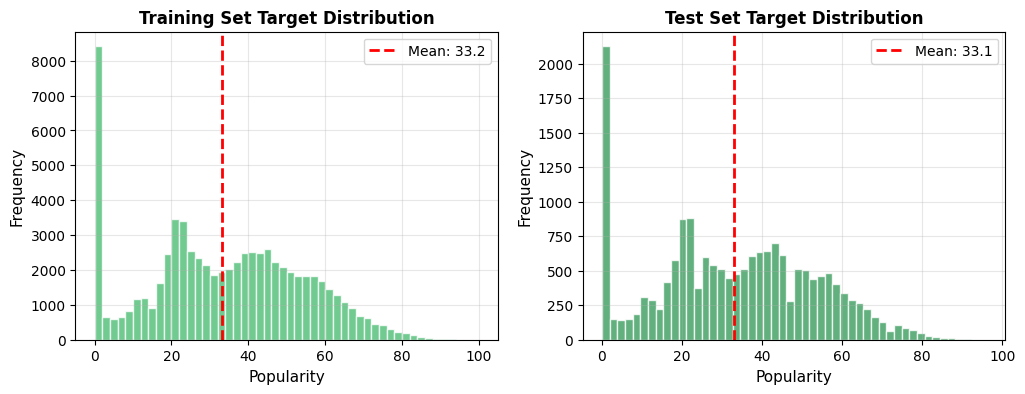

In [11]:
# =============================================================================
# VERIFY TARGET DISTRIBUTION IN TRAIN VS TEST
# =============================================================================
# A good split should have similar target distributions in both sets
# Large differences might indicate the split is unrepresentative

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Color scheme matching project theme
PRIMARY = '#4dbd74'
SECONDARY = '#3a9d5d'

# Plot training target distribution
axes[0].hist(y_train, bins=50, color=PRIMARY, edgecolor='white', alpha=0.8)
axes[0].axvline(y_train.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y_train.mean():.1f}')
axes[0].set_xlabel('Popularity', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Training Set Target Distribution', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot test target distribution
axes[1].hist(y_test, bins=50, color=SECONDARY, edgecolor='white', alpha=0.8)
axes[1].axvline(y_test.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y_test.mean():.1f}')
axes[1].set_xlabel('Popularity', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Test Set Target Distribution', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)


plt.show()



<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## Section 4: Feature Scaling with StandardScaler

Now I'll apply StandardScaler to the continuous features:
1. **Fit** the scaler on training data only
2. **Transform** both training and test data using the fitted scaler

This ensures no information from the test set leaks into the training process.

In [12]:
# =============================================================================
# INITIALIZE STANDARDSCALER
# =============================================================================
# StandardScaler transforms features to have:
#   - Mean = 0
#   - Standard Deviation = 1
#
# Formula: z = (x - μ) / σ
#   where μ = mean, σ = standard deviation
#
# This is also known as Z-score normalization

scaler = StandardScaler()

print("✅ StandardScaler initialized")
print("\n📝 StandardScaler will transform features to:")
print("   - Mean = 0")
print("   - Standard Deviation = 1")

✅ StandardScaler initialized

📝 StandardScaler will transform features to:
   - Mean = 0
   - Standard Deviation = 1


In [13]:
# =============================================================================
# EXAMINE FEATURES BEFORE SCALING
# =============================================================================
# Look at the statistics of features to be scaled BEFORE transformation

print("=" * 70)
print("FEATURES TO SCALE - BEFORE SCALING (Training Set)")
print("=" * 70)

before_scaling_stats = X_train[features_to_scale].describe().T[['mean', 'std', 'min', 'max']]
print(before_scaling_stats.round(2).to_string())

FEATURES TO SCALE - BEFORE SCALING (Training Set)
                             mean        std      min         max
duration_ms             229216.65  115213.30  8586.00  5237295.00
duration_min                 3.82       1.92     0.14       87.29
loudness                    -8.17       4.19   -18.14        2.71
tempo                      122.06      30.09     0.00      243.37
tempo_log                    4.78       0.31     0.00        5.50
track_genre                 33.22      11.62     2.54       59.14
energy_x_danceability        0.36       0.18     0.00        0.96
loudness_x_energy           -4.34       1.89   -18.14        2.71
valence_x_danceability       0.29       0.20     0.00        0.96


In [14]:
# =============================================================================
# FIT AND TRANSFORM TRAINING DATA
# =============================================================================
# fit_transform() does two things:
#   1. fit(): Calculates mean and std from training data
#   2. transform(): Applies the transformation to training data
#
# IMPORTANT: We only fit on training data to prevent data leakage!

# Create copies to avoid modifying original DataFrames
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Fit scaler on training data and transform training data
X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])

print("✅ Scaler fitted on training data")
print("✅ Training data transformed")
print(f"\n📊 Scaler learned parameters:")
print(f"   Features scaled: {len(features_to_scale)}")

# Show learned parameters
scaler_params = pd.DataFrame({
    'feature': features_to_scale,
    'mean (μ)': scaler.mean_,
    'std (σ)': scaler.scale_
})
print("\nLearned Mean and Std for each feature:")
print(scaler_params.to_string(index=False))

✅ Scaler fitted on training data
✅ Training data transformed

📊 Scaler learned parameters:
   Features scaled: 9

Learned Mean and Std for each feature:
               feature      mean (μ)       std (σ)
           duration_ms 229216.646980 115212.497062
          duration_min      3.820277      1.920208
              loudness     -8.168809      4.193151
                 tempo    122.060097     30.088222
             tempo_log      4.776644      0.313572
           track_genre     33.222171     11.624650
 energy_x_danceability      0.363269      0.179843
     loudness_x_energy     -4.338248      1.887840
valence_x_danceability      0.286434      0.200265


In [15]:
# =============================================================================
# TRANSFORM TEST DATA (Using training statistics)
# =============================================================================
# transform() applies the SAME transformation learned from training data
# This is crucial: test data is scaled using TRAINING mean and std
#
# DO NOT use fit_transform() on test data - that would cause data leakage!

X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

print("✅ Test data transformed using training statistics")
print("\n📝 Note: Test data was NOT fitted, only transformed")
print("   This prevents data leakage from test set into training process")

✅ Test data transformed using training statistics

📝 Note: Test data was NOT fitted, only transformed
   This prevents data leakage from test set into training process


In [16]:
# =============================================================================
# EXAMINE FEATURES AFTER SCALING
# =============================================================================
# Verify that scaled features now have mean ≈ 0 and std ≈ 1

print("=" * 70)
print("FEATURES AFTER SCALING (Training Set)")
print("=" * 70)

after_scaling_stats = X_train_scaled[features_to_scale].describe().T[['mean', 'std', 'min', 'max']]
print(after_scaling_stats.round(4).to_string())

print("\n✅ All scaled features now have mean ≈ 0 and std ≈ 1")

FEATURES AFTER SCALING (Training Set)
                        mean  std      min      max
duration_ms             -0.0  1.0  -1.9150  43.4682
duration_min            -0.0  1.0  -1.9150  43.4682
loudness                 0.0  1.0  -2.3788   2.5952
tempo                   -0.0  1.0  -4.0567   4.0319
tempo_log               -0.0  1.0 -15.2330   2.3027
track_genre             -0.0  1.0  -2.6398   2.2296
energy_x_danceability    0.0  1.0  -2.0199   3.2985
loudness_x_energy        0.0  1.0  -7.3128   3.7338
valence_x_danceability   0.0  1.0  -1.4303   3.3555

✅ All scaled features now have mean ≈ 0 and std ≈ 1


In [17]:
# =============================================================================
# VERIFY UNSCALED FEATURES REMAIN UNCHANGED
# =============================================================================
# Confirm that binary, bounded, and ordinal features were NOT modified

unscaled_features = binary_features + bounded_features + ordinal_features

print("=" * 70)
print("UNSCALED FEATURES - VERIFICATION")
print("=" * 70)

# Check if values are identical before and after
all_unchanged = True
for feat in unscaled_features:
    if not X_train[feat].equals(X_train_scaled[feat]):
        print(f"❌ {feat} was modified!")
        all_unchanged = False

if all_unchanged:
    print(f"✅ All {len(unscaled_features)} unscaled features remain unchanged")

# Show sample of unscaled features
print("\nSample unscaled feature values (first 5 rows):")
print(X_train_scaled[binary_features[:3]].head().to_string())

UNSCALED FEATURES - VERIFICATION
✅ All 15 unscaled features remain unchanged

Sample unscaled feature values (first 5 rows):
       explicit  mode  is_instrumental
29054         0     0                0
30418         0     0                0
5875          0     0                0
68198         0     1                0
57668         1     0                0


<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## Section 5: Visualization of Scaling Effect

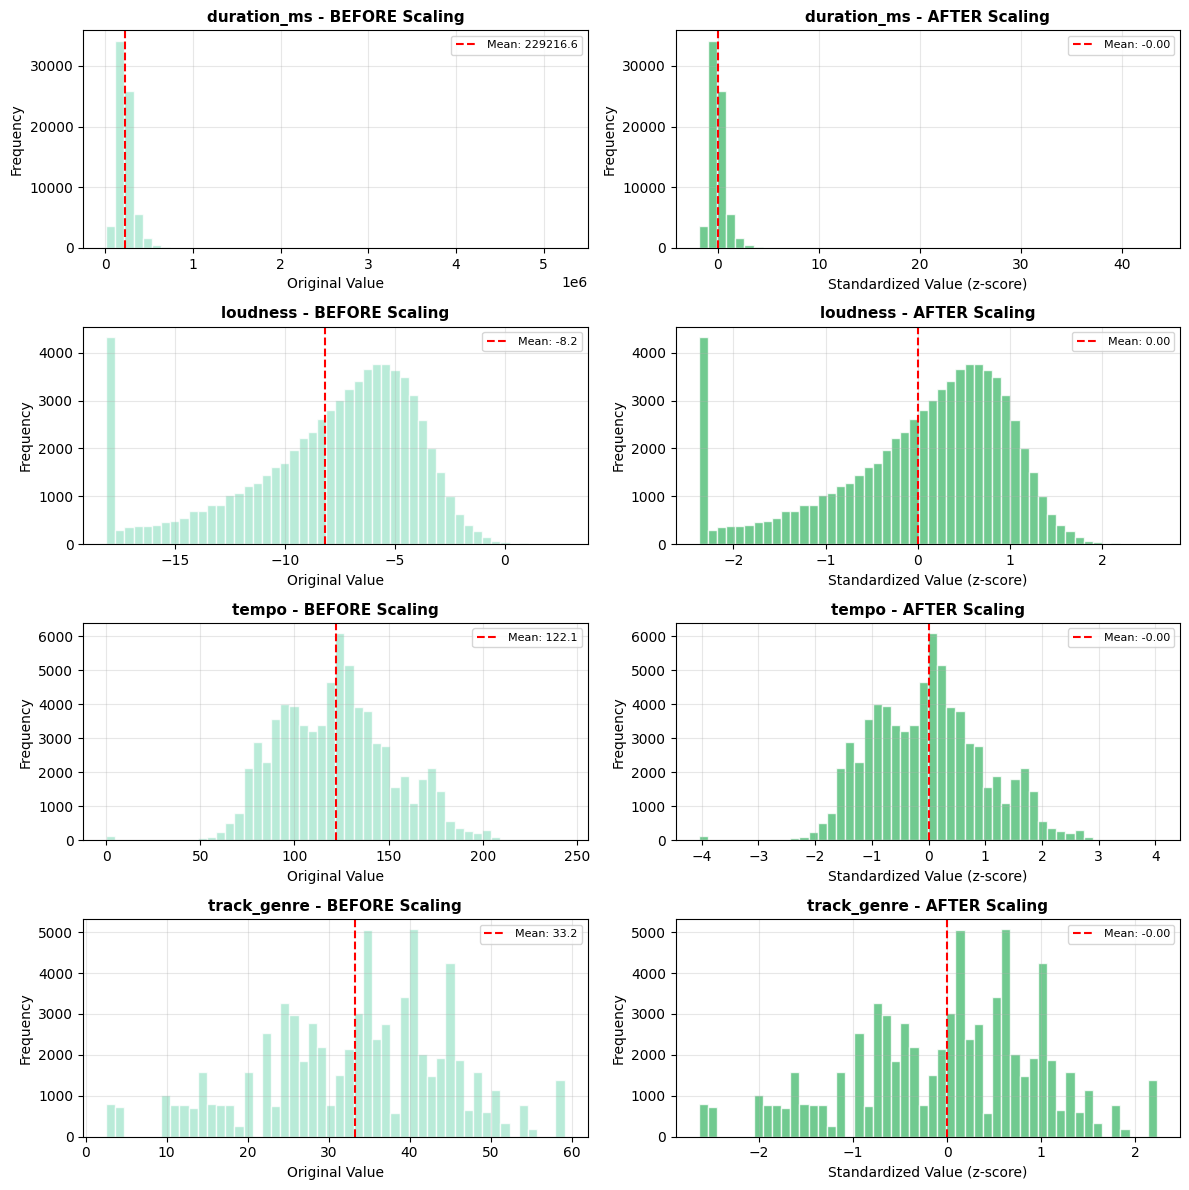

In [19]:
# =============================================================================
# VISUALIZE BEFORE VS AFTER SCALING
# =============================================================================
# Compare distributions of key features before and after scaling

# Select features to visualize (most different scales)
viz_features = ['duration_ms', 'loudness', 'tempo', 'track_genre']

fig, axes = plt.subplots(len(viz_features), 2, figsize=(12, 3*len(viz_features)))

for i, feat in enumerate(viz_features):
    # Before scaling (original values)
    axes[i, 0].hist(X_train[feat], bins=50, color='#a8e6cf', edgecolor='white', alpha=0.8)
    axes[i, 0].set_title(f'{feat} - BEFORE Scaling', fontsize=11, fontweight='bold')
    axes[i, 0].set_xlabel('Original Value')
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].axvline(X_train[feat].mean(), color='red', linestyle='--', label=f'Mean: {X_train[feat].mean():.1f}')
    axes[i, 0].legend(fontsize=8)
    axes[i, 0].grid(True, alpha=0.3)
    
    # After scaling (standardized values)
    axes[i, 1].hist(X_train_scaled[feat], bins=50, color='#4dbd74', edgecolor='white', alpha=0.8)
    axes[i, 1].set_title(f'{feat} - AFTER Scaling', fontsize=11, fontweight='bold')
    axes[i, 1].set_xlabel('Standardized Value (z-score)')
    axes[i, 1].set_ylabel('Frequency')
    axes[i, 1].axvline(X_train_scaled[feat].mean(), color='red', linestyle='--', label=f'Mean: {X_train_scaled[feat].mean():.2f}')
    axes[i, 1].legend(fontsize=8)
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## Section 6: Save Scaled Data and Scaler Object

In [20]:
# =============================================================================
# SAVE SCALER OBJECT
# =============================================================================
# Save the fitted scaler so it can be reused:
#   - For transforming new/unseen data in production
#   - For ensuring consistent preprocessing across experiments
#
# Using joblib for efficient serialization of scikit-learn objects

# Ensure models directory exists
os.makedirs('../models', exist_ok=True)

# Save the scaler
scaler_path = '../models/standard_scaler.joblib'
joblib.dump(scaler, scaler_path)

print("=" * 60)
print("SCALER SAVED")
print("=" * 60)
print(f"\n📁 Path: {scaler_path}")
print(f"📊 Features scaled: {features_to_scale}")
print("\n📝 Usage in future notebooks:")
print("   scaler = joblib.load('../models/standard_scaler.joblib')")
print("   X_new_scaled = scaler.transform(X_new[features_to_scale])")

SCALER SAVED

📁 Path: ../models/standard_scaler.joblib
📊 Features scaled: ['duration_ms', 'duration_min', 'loudness', 'tempo', 'tempo_log', 'track_genre', 'energy_x_danceability', 'loudness_x_energy', 'valence_x_danceability']

📝 Usage in future notebooks:
   scaler = joblib.load('../models/standard_scaler.joblib')
   X_new_scaled = scaler.transform(X_new[features_to_scale])


In [21]:
# =============================================================================
# SAVE FEATURE LISTS FOR REFERENCE
# =============================================================================
# Save the feature categorization so modeling notebook knows which features
# were scaled and which were not

import json

feature_config = {
    'target': target,
    'features_scaled': features_to_scale,
    'features_binary': binary_features,
    'features_bounded': bounded_features,
    'features_ordinal': ordinal_features,
    'all_features': list(X.columns)
}

config_path = '../models/feature_config.json'
with open(config_path, 'w') as f:
    json.dump(feature_config, f, indent=2)

print(f"✅ Feature configuration saved to {config_path}")

✅ Feature configuration saved to ../models/feature_config.json


In [22]:
# =============================================================================
# SAVE SCALED TRAIN AND TEST SETS
# =============================================================================
# Save the preprocessed, scaled data for direct use in modeling
# This avoids having to repeat scaling in the modeling notebook

# Ensure data directory exists
os.makedirs('../data', exist_ok=True)

# Save training data
X_train_scaled.to_csv('../data/X_train_scaled.csv', index=False)
y_train.to_csv('../data/y_train.csv', index=False)

# Save test data
X_test_scaled.to_csv('../data/X_test_scaled.csv', index=False)
y_test.to_csv('../data/y_test.csv', index=False)

print("=" * 60)
print("SCALED DATA SAVED")
print("=" * 60)
print("\n📁 Training data:")
print(f"   ../data/X_train_scaled.csv ({X_train_scaled.shape})")
print(f"   ../data/y_train.csv ({y_train.shape})")
print("\n📁 Test data:")
print(f"   ../data/X_test_scaled.csv ({X_test_scaled.shape})")
print(f"   ../data/y_test.csv ({y_test.shape})")

SCALED DATA SAVED

📁 Training data:
   ../data/X_train_scaled.csv ((71792, 24))
   ../data/y_train.csv ((71792,))

📁 Test data:
   ../data/X_test_scaled.csv ((17948, 24))
   ../data/y_test.csv ((17948,))


In [23]:
# =============================================================================
# FINAL VERIFICATION
# =============================================================================
# Reload saved files to confirm they were saved correctly

print("=" * 60)
print("FINAL VERIFICATION - RELOADING SAVED FILES")
print("=" * 60)

# Reload and verify
X_train_check = pd.read_csv('../data/X_train_scaled.csv')
y_train_check = pd.read_csv('../data/y_train.csv')
X_test_check = pd.read_csv('../data/X_test_scaled.csv')
y_test_check = pd.read_csv('../data/y_test.csv')

print(f"\n✅ X_train_scaled: {X_train_check.shape}")
print(f"✅ y_train: {y_train_check.shape}")
print(f"✅ X_test_scaled: {X_test_check.shape}")
print(f"✅ y_test: {y_test_check.shape}")

print(f"\n📊 Columns in X_train_scaled:")
print(X_train_check.columns.tolist())

FINAL VERIFICATION - RELOADING SAVED FILES

✅ X_train_scaled: (71792, 24)
✅ y_train: (71792, 1)
✅ X_test_scaled: (17948, 24)
✅ y_test: (17948, 1)

📊 Columns in X_train_scaled:
['duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'duration_min', 'energy_x_danceability', 'loudness_x_energy', 'valence_x_danceability', 'is_instrumental', 'has_vocals', 'is_speech_heavy', 'tempo_log', 'duration_category', 'track_genre']


<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## 📋 Notebook Summary

### What Was Accomplished

| Task | Details | Result |
|------|---------|--------|
| Train-Test Split | 80/20 split, random_state=42 | 71,792 train / 17,948 test |
| Feature Categorization | Identified 9 features to scale | Documented scaling decisions |
| StandardScaler | Fit on train, transform train+test | Mean=0, Std=1 for scaled features |
| Save Outputs | Scaler + scaled data | Ready for modeling |

### Key Decisions Explained

1. **Why Split Before Scaling?**
   - Prevents data leakage
   - Test statistics don't influence training transformation
   - More realistic model evaluation

2. **Why StandardScaler?**
   - Works with negative values (unlike MinMaxScaler)
   - Linear Regression assumes features on similar scale
   - Z-score normalization is robust

3. **Why Not Scale All Features?**
   - Binary features: 0/1 has clear meaning
   - Bounded 0-1 features: Already normalized
   - Ordinal features: Small integer ranges

### Output Files

- `../data/X_train_scaled.csv` - Scaled training features
- `../data/y_train.csv` - Training target
- `../data/X_test_scaled.csv` - Scaled test features
- `../data/y_test.csv` - Test target
- `../models/standard_scaler.joblib` - Fitted scaler object
- `../models/feature_config.json` - Feature categorization

### Next Steps (Notebook 07)

The scaled data is now ready for:
1. **Model Training** - Linear Regression, Random Forest, Stacking Regressor
2. **Cross-Validation** - K-Fold CV for robust evaluation
3. **Hyperparameter Tuning** - Optimize model parameters
4. **Model Comparison** - Evaluate and select best model